In [1]:
from decouple import config
import os
import pandas as pd
from nilearn import datasets, plotting, image
from sklearn import linear_model
from fNeuro.utils.pickling import load_pickle 
from fNeuro.ml.ml_functions import estimate_regression_model
from fNeuro.connectivity.connectivity import get_correlation_long_df, get_mean_correlation_matrix
from fNeuro.connectivity.organise_networks import order_networks
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

In [2]:
#ml imports
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

In [3]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
group = np.asarray(list(time_series['an'].values()) + list(time_series['hc'].values()))

In [4]:
autistic_traits = pd.read_csv(os.path.join(resting_path, 'autistic_traits_neuroimaging.csv'))
autistic_traits['B_Number'] = autistic_traits['B_Number'].str.rstrip()
autistic_traits = autistic_traits.drop(autistic_traits[autistic_traits['B_Number'].str.contains('B2010')].index).reset_index(drop=True)
autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
participant_order = load_pickle(os.path.join(resting_path, 'measures', 'connectome_participant_order'))
order = [re.findall('B\d\d\d\d', participant)[0] for participant in participant_order]
connectome_dict = dict(zip(order, connectome))
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })


/tmp/ipykernel_1325362/3537036702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'


In [42]:
correlation_matrix = get_mean_correlation_matrix(group, msdl['labels'])
an_df = get_correlation_long_df(correlation_matrix['an_mean_correlations'], msdl_overview_df)

## AQ10

In [6]:
aq_df = autistic_traits[['B_Number', 'aq10']].dropna().reset_index(drop=True)
y_aq = aq_df['aq10'].values
x_aq = np.array([connectome_dict.get(key) for key in aq_df['B_Number'].values])

<Axes: ylabel='Count'>

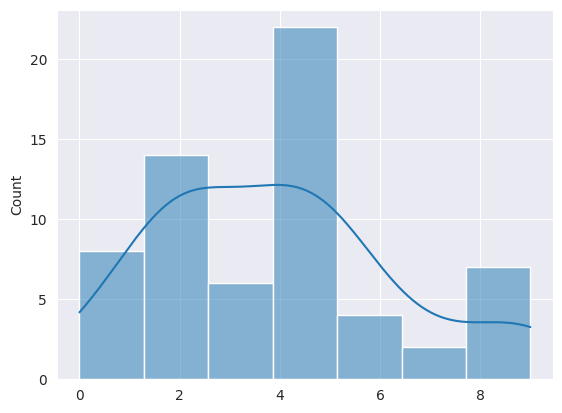

In [7]:
sns.histplot(data=y_aq, kde=True)

In [50]:
from sklearn.feature_selection import r_regression
test = r_regression(x_aq, y_aq)
index = np.where((test > 0.1) | (test < -0.1))[0]
x = x_aq[0:, index]
an_df_aq = an_df.iloc[index]

In [9]:
lasso = linear_model.LassoCV(cv=10, n_jobs=3)
scores_lasso = estimate_regression_model(lasso, x, y_aq)
print('R2: ', scores_lasso['r2'].mean())
print('MAE: ', scores_lasso['MAE'].mean())
print('MSE: ', scores_lasso['MSE'].mean())

R2:  -0.07360712884466067
MAE:  -2.088226657488294
MSE:  -6.661414328771843


In [10]:
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
scores_ridge = estimate_regression_model(ridge, x, y_aq)
print('R2: ', scores_ridge['r2'].mean())
print('MAE: ', scores_ridge['MAE'].mean())
print('MSE: ', scores_ridge['MSE'].mean())

R2:  0.3263828720499099
MAE:  -1.578087687629402
MSE:  -4.169635627756922


In [11]:
svc_parameters = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
svm_regression = GridSearchCV(svm.SVR(kernel='linear', gamma="auto"), svc_parameters)
svm_regression.fit(x, y_aq)
scores_svm = estimate_regression_model(svm_regression, x, y_aq)
print('R2: ', scores_svm['r2'].mean())
print('MAE: ', scores_svm['MAE'].mean())
print('MSE: ', scores_svm['MSE'].mean())

R2:  0.33082814807615496
MAE:  -1.5748808284525329
MSE:  -4.142859800675713


In [12]:
tree_parm = {'max_depth':[3, 5, 7]}
ran_forest = GridSearchCV(RandomForestRegressor(random_state=0), tree_parm)
score_ran = estimate_regression_model(ran_forest, x, y_aq)
print('R2: ', score_ran['r2'].mean())
print('MAE: ', score_ran['MAE'].mean())
print('MSE: ', score_ran['MSE'].mean())

R2:  0.10258373789378583
MAE:  -1.9906960863227325
MSE:  -5.570562437215904


In [13]:
estimators = [('ridge',linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])), ('svr', svm.SVR(kernel='linear', gamma="auto"))]
stacked_estimator = StackingRegressor(estimators)
stacked_estimator_model = estimate_regression_model(stacked_estimator, x, y_aq)
print('R2: ', stacked_estimator_model['r2'].mean())
print('MAE: ', stacked_estimator_model['MAE'].mean())
print('MSE: ', stacked_estimator_model['MSE'].mean())

R2:  0.3091507651547773
MAE:  -1.6343381264744192
MSE:  -4.279206894790424


In [14]:
comp_score_dict = {'r2': pd.DataFrame(data={
                                            'lasso': scores_lasso['r2'],
                                            'ridge': scores_ridge['r2'],
                                            'random_forest': score_ran['r2'],
                                            'svr': scores_svm['r2'],
                                            'stacked': stacked_estimator_model['r2'],
                                                }),
                'MAE': pd.DataFrame(data={
                                            'lasso': scores_lasso['MAE'],
                                            'ridge': scores_ridge['MAE'],
                                            'random_forest': score_ran['MAE'],
                                            'svr': scores_svm['MAE'],
                                            'stacked': stacked_estimator_model['MAE'],
                                                }),
                'MSE': pd.DataFrame(data={
                                            'lasso': scores_lasso['MSE'],
                                            'ridge': scores_ridge['MSE'],
                                            'random_forest': score_ran['MSE'],
                                            'svr': scores_svm['MSE'],
                                            'stacked': stacked_estimator_model['MSE'],
                                                })
}


<Axes: xlabel='r2', ylabel='Model'>

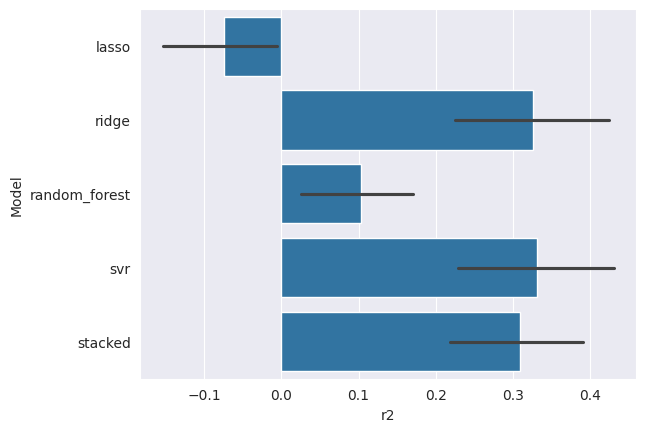

In [15]:
sns.barplot(data=pd.melt(comp_score_dict['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model')

<Axes: xlabel='Negative Mean Absolute Error', ylabel='Model'>

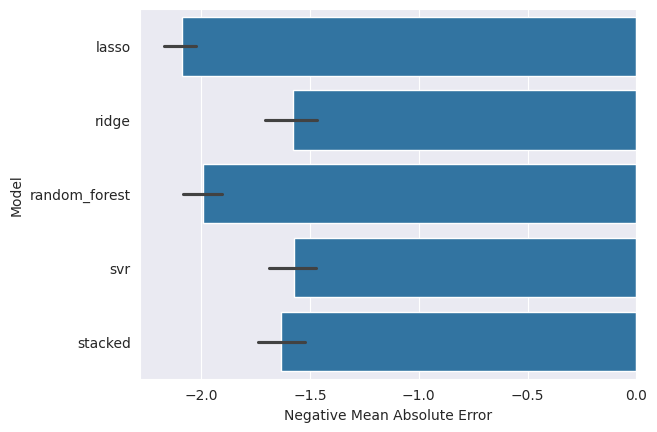

In [16]:
sns.barplot(data=pd.melt(comp_score_dict['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model')

<Axes: xlabel='Negative Mean Squared Error', ylabel='Model'>

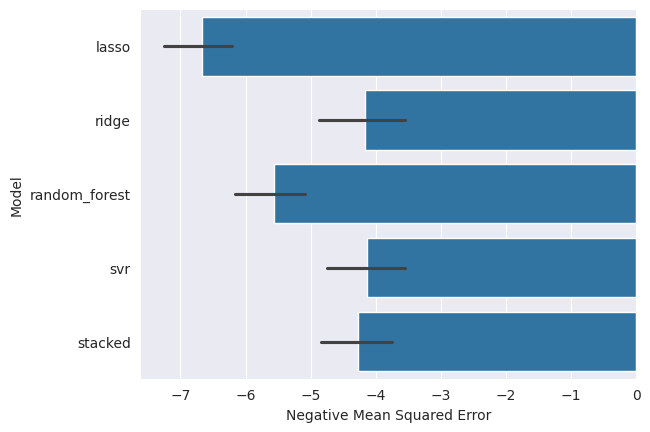

In [17]:
sns.barplot(data=pd.melt(comp_score_dict['MSE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Squared Error'}), 
                   x='Negative Mean Squared Error', y='Model')

In [51]:
an_df_aq['svr_values'] = svm_regression.best_estimator_.coef_.T

/tmp/ipykernel_1325362/3224315592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an_df_aq['svr_values'] = svm_regression.best_estimator_.coef_.T


In [52]:
an_df_aq

,corr_names,correlation,network_names,svr_values
5,Striate - L DMN,-2.378428,Striate - DMN,-0.003066
6,L Aud - Med DMN,2.629387,Aud - DMN,0.000949
7,R Aud - Med DMN,2.301681,Aud - DMN,-0.003150
8,Striate - Med DMN,-3.954418,Striate - DMN,-0.002976
9,L DMN - Med DMN,-1.002768,DMN - DMN,-0.000536
...,...,...,...,...
731,Broca - R Ant IPS,3.049106,Language - Ant IPS,-0.006868
732,Sup Front S - R Ant IPS,1.345453,Language - Ant IPS,-0.000484
735,Cereb - R Ant IPS,-0.965142,Cereb - Ant IPS,-0.000754
736,Dors PCC - R Ant IPS,2.681498,Dors PCC - Ant IPS,-0.007447


In [48]:
def seggregate_networks(network_vals: dict):
    '''
    Function to concat the output of order networks
    into two dataframes

    Parameters
    ----------
    network_vals: dict
        output from seggregate_networks function
    
    Returns
    -------
    dict: Dictionary object
        dict object of within network and
        between network concat dataframes

    '''
    within_df = []
    between_df = []
    for key in network_vals.keys():
        if len(network_vals[key]['within']) > 0:
            within_df.append(network_vals[key]['within'])
        if len(network_vals[key]['between']) > 0:
            between_df.append(network_vals[key]['between'])
    return {
        'within_df': pd.concat(within_df).sort_values(by='svr_values',key=abs, ascending=False).reset_index(drop=True),
        'between_df': pd.concat(between_df).sort_values(by='svr_values',key=abs, ascending=False).reset_index(drop=True)
    }

In [53]:
network_vals = order_networks(msdl_overview_df, an_df_aq, 'network_names')
network_seg = seggregate_networks(network_vals)

In [54]:
network_seg['within_df'].iloc[0]

corr_names         L Par - L DLPFC
correlation              -1.228584
network_names    L V Att - L V Att
svr_values                0.007585
Name: 0, dtype: object

In [55]:
network_seg['between_df'].iloc[0]

corr_names       R Aud - L IPS
correlation          -3.592281
network_names      Aud - D Att
svr_values            0.009736
Name: 0, dtype: object

## ADOS


In [24]:
ados_df = autistic_traits[['B_Number', 'ADOS total']].dropna().reset_index(drop=True)
y_ados = ados_df['ADOS total'].values
x_ados = np.array([connectome_dict.get(key) for key in ados_df['B_Number'].values])

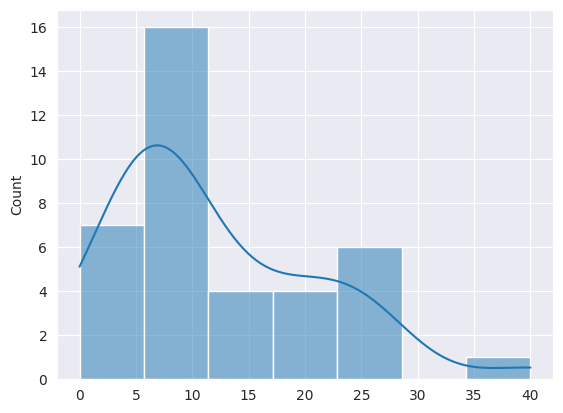

In [25]:
sns.histplot(data=y_ados, kde=True)
plt.show()

In [45]:
from sklearn.feature_selection import r_regression
from sklearn.metrics import mean_absolute_error
test = r_regression(x_ados, y_ados)
index = np.where((test > 0.1) | (test < -0.1))[0]
x_ados = x_ados[0:, index]
an_df_ados = an_df.iloc[index]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x_ados, y_ados,  random_state=0, test_size=0.3
)

In [28]:
svc_parameters = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
svr_ados = GridSearchCV(svm.SVR(kernel='linear', gamma="auto"), svc_parameters)
svr_ados.fit(X_train, y_train)
svr_score_ados = svr_ados.score(X_test, y_test)
svr_mae_ados = mean_absolute_error(y_test, svr_ados.predict(X_test))
print('R2: ', svr_score_ados )
print('MAE: ', svr_mae_ados)

R2:  0.4094377487884532
MAE:  6.586887943425542


In [29]:
lasso_ados = linear_model.LassoCV(cv=10, n_jobs=3)
lasso_ados.fit(X_train, y_train)
lasso_ados_score = lasso_ados.score(X_test, y_test)
lasso_mae_ados = mean_absolute_error(y_test, lasso_ados.predict(X_test))
print('R2: ', lasso_ados_score)
print('MAE: ', lasso_mae_ados)

R2:  -0.4662011646338353
MAE:  9.775684399991016


In [30]:
ridge_ados = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
ridge_ados.fit(X_train, y_train)
ridge_ados_score = ridge_ados.score(X_test, y_test)
ridge_mae_ados = mean_absolute_error(y_test, ridge_ados.predict(X_test))
print('R2: ', ridge_ados_score)
print('MAE: ', ridge_mae_ados)

R2:  0.41401786498378534
MAE:  6.5615542585252795


In [31]:
tree_parm = {'max_depth':[3, 5, 7]}
ran_forest_ados = GridSearchCV(RandomForestRegressor(random_state=0), tree_parm)
ran_forest_ados.fit(X_train, y_train)
ran_forest_ados_score = ran_forest_ados.score(X_test, y_test)
ran_forest_mae_ados = mean_absolute_error(y_test, ran_forest_ados.predict(X_test))
print('R2: ', ran_forest_ados_score)
print('MAE: ', ran_forest_mae_ados)

R2:  -0.192371255441961
MAE:  9.029880819684129


In [39]:
comp_score_dict_ados = {'r2': pd.DataFrame(data={
                                            'lasso': lasso_ados_score,
                                            'ridge': ridge_ados_score,
                                            'random_forest': ran_forest_ados_score,
                                            'svr': svr_score_ados,
                                                }, index=[0, ]),
                'MAE': pd.DataFrame(data={
                                        'lasso': lasso_mae_ados,
                                        'ridge': ridge_mae_ados,
                                        'random_forest': ran_forest_mae_ados,
                                        'svr': svr_mae_ados,
                                                },index=[0, ]),
}


<Axes: >

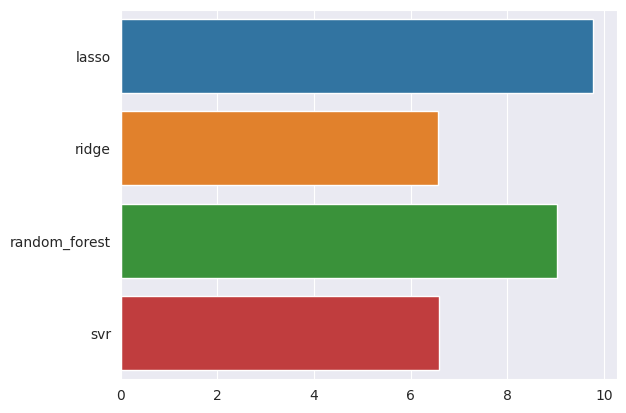

In [40]:
sns.barplot(data=comp_score_dict_ados['MAE'], orient="y")

<Axes: >

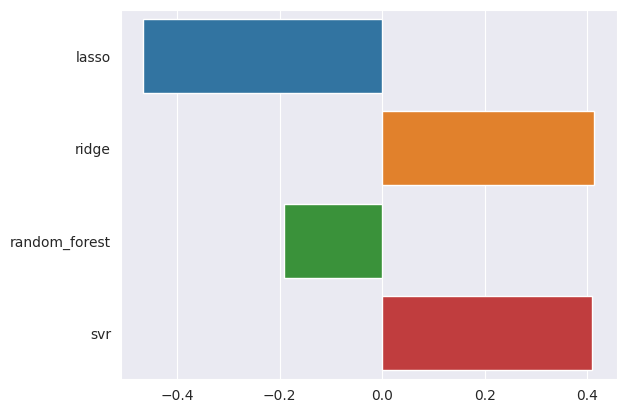

In [41]:
sns.barplot(data=comp_score_dict_ados['r2'], orient="y")

In [47]:
an_df_ados['svr_values'] = svr_ados.best_estimator_.coef_.T

/tmp/ipykernel_1325362/3838282097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an_df_ados['svr_values'] = svr_ados.best_estimator_.coef_.T


In [60]:
network_vals_ados = order_networks(msdl_overview_df, an_df_ados, 'network_names')
network_seg_ados = seggregate_networks(network_vals_ados)


In [61]:
network_seg_ados['within_df'].iloc[0]

corr_names             L STS - R STS
correlation                 0.799667
network_names    Temporal - Temporal
svr_values                  0.010529
Name: 0, dtype: object

In [62]:
network_seg_ados['between_df'].iloc[0]

corr_names          L DLPFC - L STS
correlation                1.203768
network_names    L V Att - Temporal
svr_values                -0.018733
Name: 0, dtype: object